In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor



def _merge_external_data(X):


    ########################### Date data ##################################

  #  filepath_one = os.path.join(
   #     os.path.dirname(__file__), 'external_data.csv'
   # )

    ####### Make sure that DateOfDeparture is of dtype datetime #######

    X = X.copy()  # modify a copy of X
    X.rename
    X.loc[:, "DateOfDeparture"] = pd.to_datetime(X['DateOfDeparture'])
    # Parse date to also be of dtype datetime
    data=pd.read_csv(r'C:\Users\yanis\01 Projets\01 Python Projects\Projet_Air_Passenger\air_passengers\submissions\Test_1\external_data.csv',index_col=0,parse_dates=["Date"])
    
    ####### Take data for the departure airport #######

    X_weather = data[['Date', 'AirPort', 'Max TemperatureC','Events']]
    X_weather = X_weather.rename(
        columns={'Date': 'DateOfDeparture', 'AirPort': 'Departure', 'Max TemperatureC':'temperature_depart','Events':'Events_depart'}
    )

    X_merged = pd.merge(
        X, X_weather, how='left', on=['DateOfDeparture', 'Departure'], sort=False
    )

    ####### Take data for the arrival airport #######

    X_weather = data[['Date', 'AirPort', 'Max TemperatureC','Events']]

    X_weather = X_weather.rename(
        columns={'Date': 'DateOfDeparture', 'AirPort': 'Arrival', 'Max TemperatureC':'temperature_arrival', 'Events':'Events_arrival'}
    )

    X_merged_meteo = pd.merge(
        X_merged, X_weather, how='left', on=['DateOfDeparture', 'Arrival'], sort=False
    )
    
    
    ########################### airport data ##################################

    X = X_merged_meteo.copy() 

    X_airport = data[['Date','AirPort', 'wage median','beach','passenger per year','population','latitude_deg','longitude_deg','score']]
    X_airport = X_airport.rename(
        columns={'Date': 'DateOfDeparture','AirPort':'Departure', 'wage median':'wage_median_depart', 'beach':'beach_depart', 'passenger per year':'passenger_per_year_depart',
            'population':'population_depart', 'latitude_deg':'latitude_deg_depart', 'longitude_deg':'longitude_deg_depart','score':'score_depart'}
    )

    X_merged_airport = pd.merge(
        X, X_airport, how='left', on='Departure', sort=False
    ).drop(columns=['DateOfDeparture_y']).drop_duplicates().rename(
        columns={'DateOfDeparture_x': 'DateOfDeparture'})
    
    

      ####### Take data for the arrival airport #######
    
    
    X = X_merged_airport.copy()


    X_airport = data[['Date','AirPort', 'wage median','beach','passenger per year','population','latitude_deg','longitude_deg','score']]
    X_airport = X_airport.rename(
        columns={'Date':'DateOfDeparture','AirPort':'Arrival', 'wage median':'wage_median_arrival', 'beach':'beach_arrival', 'passenger per year':'passenger_per_year_arrival',
            'population':'population_arrival','latitude_deg':'latitude_deg_arrival','longitude_deg':'longitude_deg_arrival','score':'score_arrival'}
    )

    X_merged_airport = pd.merge(
        X, X_airport, how='left', on=['DateOfDeparture','Arrival'], sort=False
    )
    
      ######################## stocks fuel holiday data ###################################

    X = X_merged_airport.copy()

    data_stocks_fuel_holiday = data[['Date', 'AirPort', 'Open','prix','is_holiday']]
    data_stocks_fuel_holiday = data_stocks_fuel_holiday.rename(
        columns={'Date': 'DateOfDeparture','AirPort':'Arrival'})
    X_merged = pd.merge(
        X, data_stocks_fuel_holiday, how='left', on=['DateOfDeparture'], sort=False)
    
    
    ######################## stocks fuel holiday data ###################################

    X = X_merged_airport.copy()

    data_stocks_fuel_holiday = data[['Date', 'AirPort', 'Open','prix','is_holiday']]
    data_stocks_fuel_holiday = data_stocks_fuel_holiday.rename(
        columns={'Date': 'DateOfDeparture','AirPort':'Arrival'})
    X_merged = pd.merge(
        X, data_stocks_fuel_holiday, how='left', on=['DateOfDeparture','Arrival'], sort=False)
    
    return X_merged
  

  

In [2]:
def _encode_data(X):

    ################# encoding the date #########################

    # Encode the date information from the DateOfDeparture columns
    X_encoded = X.copy()

    # Make sure that DateOfDeparture is of datetime format
    X_encoded.loc[:, 'DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
    # Encode the DateOfDeparture
    X_encoded.loc[:, 'year'] = X_encoded['DateOfDeparture'].dt.year
    X_encoded.loc[:, 'month'] = X_encoded['DateOfDeparture'].dt.month
    X_encoded.loc[:, 'day'] = X_encoded['DateOfDeparture'].dt.day
    X_encoded.loc[:, 'weekday'] = X_encoded['DateOfDeparture'].dt.weekday
    X_encoded.loc[:, 'week'] = X_encoded['DateOfDeparture'].dt.week
    X_encoded.loc[:, 'n_days'] = X_encoded['DateOfDeparture'].apply(
        lambda date: (date - pd.to_datetime("1970-01-01")).days
    )

    
    X_encoded['weekend'] = np.where(X_encoded['weekday'].isin([0,1]),1,0)
    X_encoded['ete'] = np.where(X_encoded['month'].isin([10,5,6]),1,0)
    
    X_encoded['beach_ete_dep'] = X_encoded['ete'] * X_encoded['beach_depart']
    X_encoded['beach_ete_arr'] = X_encoded['ete'] * X_encoded['beach_arrival']
    
    ################# encoding the meteo #########################

    # From the meteo data we supply more information
    X_encoded["precipitations_depart"]=X_encoded.apply(lambda x: 0 if pd.isnull(x['Events_depart']) else 1, axis=1)
    X_encoded["precipitations_arrival"]=X_encoded.apply(lambda x: 0 if pd.isnull(x['Events_arrival']) else 1, axis=1)
    X_encoded["diff_temp"]=X_encoded['temperature_depart']-X_encoded['temperature_arrival']

    ################# encoding the distance #########################

    # calculer la distance entre les deux aeroports


    # approximate radius of earth in km

    def haversine_vectorize(lon1, lat1, lon2, lat2):

        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

        newlon = lon2 - lon1
        newlat = lat2 - lat1
        haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

        dist = 2 * np.arcsin(np.sqrt(haver_formula ))
        km = 6367 * dist #6367 for distance in KM for miles use 3958
        return km
    
    X_encoded["distance"]=haversine_vectorize(X_encoded['longitude_deg_depart'],X_encoded['latitude_deg_depart'],X_encoded['longitude_deg_arrival'],X_encoded['latitude_deg_arrival'])

 

    ################# ending the encoding #########################

    # Finally we can drop the original columns from the dataframe
    
    #print(X_encoded.columns)
    return X_encoded.drop(columns=["DateOfDeparture","Events_depart","Events_arrival","latitude_deg_depart",
                                   "latitude_deg_arrival","longitude_deg_arrival","longitude_deg_depart"])
                                   
                            

In [3]:

def get_estimator():

    # Data augmentation transformer (add a column)
    data_merger = FunctionTransformer(_merge_external_data)
    data_encoder = FunctionTransformer(_encode_data)

    # preprocessor for categorical variables
    categorical_encoder = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="missing"),
        OrdinalEncoder()
    )
    categorical_cols = ['Arrival', 'Departure']

    preprocessor = make_column_transformer(
        (categorical_encoder, categorical_cols),
        remainder='passthrough',  # passthrough numerical columns as they are
    )

    # Regressor to do the prediction
    regressor = RandomForestRegressor(
        n_estimators=500, max_depth=10, max_features="auto", n_jobs=-1
    )

    # Create a pipeline to return a scikit-learn estimator that will
    # be used in ramp-test to do across validation
    

    
    return make_pipeline(
        data_merger, data_encoder,
        preprocessor, regressor
    )

# Test en local sur notebook

In [4]:
import problem
X, y = problem.get_train_data()

data_merger = FunctionTransformer(_merge_external_data)
data_encoder = FunctionTransformer(_encode_data)

v = data_merger.fit_transform(X)
v.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,temperature_depart,Events_depart,temperature_arrival,Events_arrival,wage_median_depart,...,wage_median_arrival,beach_arrival,passenger_per_year_arrival,population_arrival,latitude_deg_arrival,longitude_deg_arrival,score_arrival,Open,prix,is_holiday
0,2012-06-19,ORD,DFW,12.875000,9.812647,35.0,NaN,34.0,NaN,58419.666667,...,53078.666667,0,66233.791000,1242115,32.896801,-97.038002,1203175,12.50,3.729,0
1,2012-09-10,LAS,DEN,14.285714,9.466734,36.0,NaN,33.0,NaN,55440.666667,...,55482.666667,0,59852.550000,635163,39.861698,-104.672997,1103275,12.10,4.132,0
2,2012-10-05,DEN,LAX,10.863636,9.035883,6.0,Rain-Snow,22.0,Fog,55482.666667,...,59541.333333,1,73928.405667,3851202,33.942501,-118.407997,1335475,11.79,4.079,0
3,2011-10-09,ATL,ORD,11.480000,7.990202,22.0,NaN,27.0,NaN,61467.666667,...,58419.666667,1,75120.345000,2719141,41.978600,-87.904800,1503175,5.42,3.749,0
4,2012-02-21,DEN,SFO,11.450000,9.517159,8.0,NaN,16.0,NaN,55482.666667,...,82083.000000,1,49668.409667,828876,37.618999,-122.375000,1112475,8.87,3.960,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8897,2011-10-02,DTW,ATL,9.263158,7.316967,17.0,Rain,20.0,NaN,44130.000000,...,61467.666667,0,105911.923000,449016,33.636700,-84.428101,2002475,5.96,3.786,0
8898,2012-09-25,DFW,ORD,12.772727,10.641034,35.0,NaN,25.0,NaN,53078.666667,...,58419.666667,1,75120.345000,2719141,41.978600,-87.904800,1503175,10.56,4.086,0
8899,2012-01-19,SFO,LAS,11.047619,7.908705,11.0,Rain,13.0,NaN,82083.000000,...,55440.666667,0,46505.605000,593275,36.080101,-115.152000,1068475,6.06,3.854,0
8900,2013-02-03,ORD,PHL,6.076923,4.030334,-6.0,Snow,1.0,Snow,58419.666667,...,39645.333333,0,34276.636000,1551824,39.871899,-75.241096,1031075,14.43,3.927,0


In [5]:
v2=data_encoder.fit_transform(v)
v2.info()

C:\Users\yanis\Documents\Logiciels\Anaconda\envs\ramp-air-passengers\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  from ipykernel import kernelapp as app


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8902 entries, 0 to 8901
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Departure                   8902 non-null   object 
 1   Arrival                     8902 non-null   object 
 2   WeeksToDeparture            8902 non-null   float64
 3   std_wtd                     8902 non-null   float64
 4   temperature_depart          8902 non-null   float64
 5   temperature_arrival         8902 non-null   float64
 6   wage_median_depart          8902 non-null   float64
 7   beach_depart                8902 non-null   int64  
 8   passenger_per_year_depart   8902 non-null   float64
 9   population_depart           8902 non-null   int64  
 10  score_depart                8902 non-null   int64  
 11  wage_median_arrival         8902 non-null   float64
 12  beach_arrival               8902 non-null   int64  
 13  passenger_per_year_arrival  8902 

In [6]:
categorical_encoder = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder()
)

categorical_cols = ['Arrival', 'Departure']

preprocessor = make_column_transformer(
    (categorical_encoder, categorical_cols),
    remainder='passthrough')  # passthrough numerical columns as they are

In [7]:
v3=pd.DataFrame(preprocessor.fit_transform(v2),columns = v2.columns)
v3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8902 entries, 0 to 8901
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Departure                   8902 non-null   float64
 1   Arrival                     8902 non-null   float64
 2   WeeksToDeparture            8902 non-null   float64
 3   std_wtd                     8902 non-null   float64
 4   temperature_depart          8902 non-null   float64
 5   temperature_arrival         8902 non-null   float64
 6   wage_median_depart          8902 non-null   float64
 7   beach_depart                8902 non-null   float64
 8   passenger_per_year_depart   8902 non-null   float64
 9   population_depart           8902 non-null   float64
 10  score_depart                8902 non-null   float64
 11  wage_median_arrival         8902 non-null   float64
 12  beach_arrival               8902 non-null   float64
 13  passenger_per_year_arrival  8902 

In [8]:
v3.columns

Index(['Departure', 'Arrival', 'WeeksToDeparture', 'std_wtd',
       'temperature_depart', 'temperature_arrival', 'wage_median_depart',
       'beach_depart', 'passenger_per_year_depart', 'population_depart',
       'score_depart', 'wage_median_arrival', 'beach_arrival',
       'passenger_per_year_arrival', 'population_arrival', 'score_arrival',
       'Open', 'prix', 'is_holiday', 'year', 'month', 'day', 'weekday', 'week',
       'n_days', 'weekend', 'ete', 'beach_ete_dep', 'beach_ete_arr',
       'precipitations_depart', 'precipitations_arrival', 'diff_temp',
       'distance'],
      dtype='object')

In [9]:
regressor = GradientBoostingRegressor(loss='ls', learning_rate=0.05,n_estimators=1500, subsample=1.0,
                                      criterion='friedman_mse',min_samples_split=9, min_samples_leaf=5,
                                      min_weight_fraction_leaf=0.0, max_depth=4,min_impurity_decrease=0.0,
                                      min_impurity_split=None)

regressor.fit(v3,y)

from sklearn.metrics import mean_squared_error
y_pred = regressor.predict(v3)

np.sqrt(mean_squared_error(y,y_pred))

0.21555542009452527

# Test de la pipeline

In [11]:
from sklearn.model_selection import cross_val_score

pipeline = make_pipeline(data_merger, data_encoder, preprocessor, regressor)

scores = cross_val_score(
    pipeline, X, y, cv=5, scoring='neg_mean_squared_error'
)
rmse_scores = np.sqrt(-scores)

print(
    f"RMSE: {np.mean(rmse_scores):.4f} +/- {np.std(rmse_scores):.4f}"
)

C:\Users\yanis\Documents\Logiciels\Anaconda\envs\ramp-air-passengers\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  from ipykernel import kernelapp as app
C:\Users\yanis\Documents\Logiciels\Anaconda\envs\ramp-air-passengers\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  from ipykernel import kernelapp as app
C:\Users\yanis\Documents\Logiciels\Anaconda\envs\ramp-air-passengers\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  from ipykernel import kernelapp as app
C:\Users\yanis\Documents\Logiciels\Anaconda\envs\ramp-air-passengers\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Series.dt.weekofyear and Seri

RMSE: 0.3639 +/- 0.0253


# Interprétation des variables 

## Valeurs de Shape

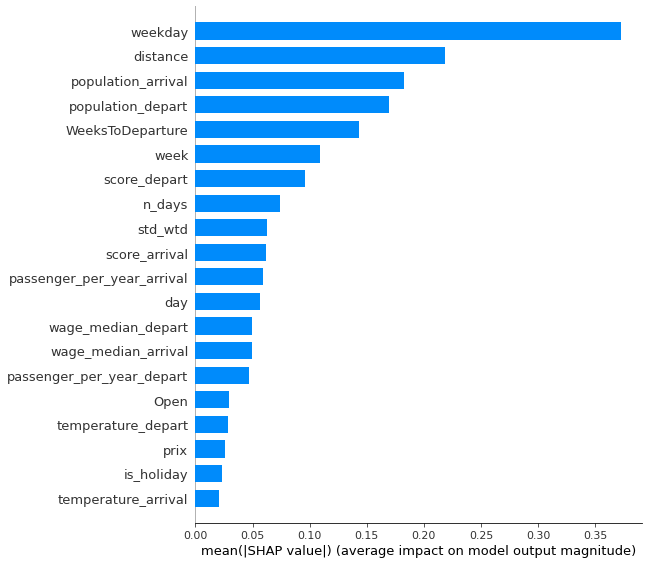

In [11]:
# Interprétation avec shap
import shap
shap_gb = shap.TreeExplainer(regressor).shap_values(v3)
shap.summary_plot(shap_gb, v3, plot_type="bar")

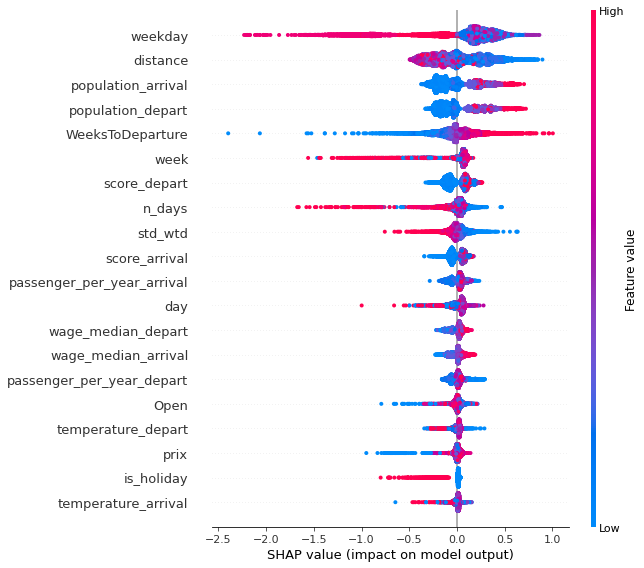

In [12]:
shap.summary_plot(shap_gb, v3)